In [1]:
# CELL 1: Imports ve Setup

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve

# Models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

ROOT = Path.cwd().parent
DATA = ROOT / "data"

print("✅ Imports completed")

✅ Imports completed


In [2]:
# CELL 2: Load Data

train_df = pd.read_csv(DATA / "train_processed.csv")
test_df = pd.read_csv(DATA / "test_processed.csv")

target = 'isFraud'
feature_cols = [c for c in train_df.columns if c != target]

X_train = train_df[feature_cols]
y_train = train_df[target]

X_test = test_df[[c for c in feature_cols if c in test_df.columns]]
y_test = test_df[target]

# Missing value handling
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Fraud rate - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")
print(f"Features: {len(feature_cols)}")

Train: (472432, 57), Test: (118108, 57)
Fraud rate - Train: 3.51%, Test: 3.44%
Features: 57


In [4]:
# CELL 3: Evaluation Functions

def plot_roc_curves(results_dict, y_test, figsize=(10, 8)):
    """
    Birden fazla model için ROC eğrilerini çizer.
    
    Args:
        results_dict: {'model_name': y_pred_proba, ...}
        y_test: Gerçek etiketler
    """
    plt.figure(figsize=figsize)
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(results_dict)))
    
    for (name, y_pred), color in zip(results_dict.items(), colors):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, 
                label=f'{name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrices(results_dict, y_test, threshold=0.5, figsize=(15, 5)):
    """
    Birden fazla model için confusion matrix çizer.
    """
    n_models = len(results_dict)
    fig, axes = plt.subplots(1, n_models, figsize=figsize)
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (name, y_pred) in zip(axes, results_dict.items()):
        y_pred_binary = (y_pred >= threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred_binary)
        
        # Normalize
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Normal', 'Fraud'],
                   yticklabels=['Normal', 'Fraud'])
        
        # Add percentages
        for i in range(2):
            for j in range(2):
                ax.text(j + 0.5, i + 0.7, f'({cm_normalized[i, j]:.1%})',
                       ha='center', va='center', fontsize=9, color='gray')
        
        ax.set_title(f'{name}\nThreshold={threshold}', fontsize=12, fontweight='bold')
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()


def plot_precision_recall_curves(results_dict, y_test, figsize=(10, 8)):
    """
    Precision-Recall eğrilerini çizer.
    """
    plt.figure(figsize=figsize)
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(results_dict)))
    
    for (name, y_pred), color in zip(results_dict.items(), colors):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred)
        plt.plot(recall, precision, color=color, lw=2,
                label=f'{name} (AP = {ap:.4f})')
    
    # Baseline (fraud rate)
    baseline = y_test.mean()
    plt.axhline(y=baseline, color='gray', linestyle='--', 
               label=f'Baseline (Fraud Rate = {baseline:.2%})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def print_evaluation_summary(results_dict, y_test):
    """
    Model karşılaştırma özeti yazdırır.
    """
    print("\n" + "=" * 70)
    print("MODEL EVALUATION SUMMARY")
    print("=" * 70)
    
    summary_data = []
    
    for name, y_pred in results_dict.items():
        roc = roc_auc_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred)
        
        # Best threshold by Youden's J
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        j_scores = tpr - fpr
        best_idx = np.argmax(j_scores)
        best_threshold = thresholds[best_idx]
        
        y_pred_binary = (y_pred >= best_threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred_binary)
        
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        summary_data.append({
            'Model': name,
            'ROC-AUC': roc,
            'Avg Precision': ap,
            'Best Threshold': best_threshold,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('ROC-AUC', ascending=False)
    
    print(summary_df.to_string(index=False))
    print("=" * 70)
    
    return summary_df

In [9]:
# CELL 4: Cross-Validation with SMOTE

def cv_with_smote(model, X, y, n_splits=5, random_state=42):
    """
    SMOTE ile Stratified K-Fold Cross Validation.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_predictions = np.zeros(len(y))
    scores = []
    
    print(f"\n{'='*50}")
    print(f"Cross-Validation with SMOTE ({n_splits} folds)")
    print(f"{'='*50}")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]
        
        # SMOTE sadece train fold'a uygulanır
        smote = SMOTE(random_state=random_state, sampling_strategy=0.5)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        
        # Model eğitimi
        if hasattr(model, 'fit'):
            model_clone = model.__class__(**model.get_params())
            
            if isinstance(model_clone, xgb.XGBClassifier):
                model_clone.fit(
                    X_train_resampled, y_train_resampled,
                    eval_set=[(X_val_fold, y_val_fold)],
                    verbose=False
                )
            elif isinstance(model_clone, lgb.LGBMClassifier):
                model_clone.fit(
                    X_train_resampled, y_train_resampled,
                    eval_set=[(X_val_fold, y_val_fold)]
                )
            else:
                model_clone.fit(X_train_resampled, y_train_resampled)
        
        # Validation prediction
        val_pred = model_clone.predict_proba(X_val_fold)[:, 1]
        oof_predictions[val_idx] = val_pred
        
        # Score
        fold_score = roc_auc_score(y_val_fold, val_pred)
        scores.append(fold_score)
        
        print(f"  Fold {fold}: AUC = {fold_score:.4f} | "
              f"Train: {len(y_train_fold)} -> {len(y_train_resampled)} (SMOTE)")
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"\n  Mean AUC: {mean_score:.4f} ± {std_score:.4f}")
    print(f"{'='*50}\n")
    
    return oof_predictions, scores

In [6]:
# CELL 5: Model Definitions

# Class imbalance için scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    early_stopping_rounds=30,
    verbosity=0
)

# LightGBM Model
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("✅ Models defined")

Scale pos weight: 27.46
✅ Models defined


In [ ]:
# CELL 6: Train Individual Models with CV + SMOTE

print("\n" + "=" * 70)
print("TRAINING INDIVIDUAL MODELS")
print("=" * 70)

# XGBoost CV
print("\n🔹 XGBoost")
xgb_oof, xgb_cv_scores = cv_with_smote(xgb_model, X_train, y_train, n_splits=5)

# LightGBM CV
print("\n🔹 LightGBM")
lgb_oof, lgb_cv_scores = cv_with_smote(lgb_model, X_train, y_train, n_splits=5)


TRAINING INDIVIDUAL MODELS

🔹 XGBoost

Cross-Validation with SMOTE (5 folds)
  Fold 1: AUC = 0.9050 | Train: 377945 -> 546999 (SMOTE)
  Fold 2: AUC = 0.9099 | Train: 377945 -> 546999 (SMOTE)
  Fold 3: AUC = 0.9108 | Train: 377946 -> 546999 (SMOTE)
  Fold 4: AUC = 0.9107 | Train: 377946 -> 547000 (SMOTE)
  Fold 5: AUC = 0.9114 | Train: 377946 -> 547000 (SMOTE)

  Mean AUC: 0.9096 ± 0.0023


🔹 LightGBM

Cross-Validation with SMOTE (5 folds)


TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'

In [11]:
# CELL 7: Train Final Models on Full Data (with SMOTE)

print("\n" + "=" * 70)
print("TRAINING FINAL MODELS ON FULL DATA")
print("=" * 70)

# SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original: {len(y_train)} samples (Fraud: {y_train.sum()})")
print(f"After SMOTE: {len(y_train_smote)} samples (Fraud: {y_train_smote.sum()})")

# Train XGBoost
xgb_final = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # SMOTE sonrası dengelendi
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    early_stopping_rounds=30,
    verbosity=0
)
xgb_final.fit(X_train_smote, y_train_smote, 
              eval_set=[(X_test, y_test)], verbose=False)
xgb_test_pred = xgb_final.predict_proba(X_test)[:, 1]

# Train LightGBM
lgb_final = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_final.fit(X_train_smote, y_train_smote,
              eval_set=[(X_test, y_test)])
lgb_test_pred = lgb_final.predict_proba(X_test)[:, 1]

print("\n✅ Individual models trained")
print(f"XGBoost Test AUC: {roc_auc_score(y_test, xgb_test_pred):.4f}")
print(f"LightGBM Test AUC: {roc_auc_score(y_test, lgb_test_pred):.4f}")


TRAINING FINAL MODELS ON FULL DATA
Original: 472432 samples (Fraud: 16599)
After SMOTE: 683749 samples (Fraud: 227916)

✅ Individual models trained
XGBoost Test AUC: 0.8736
LightGBM Test AUC: 0.8699


In [12]:
# CELL 8: Stacking Model

print("\n" + "=" * 70)
print("TRAINING STACKING MODEL")
print("=" * 70)

# Base learners (yeni instance'lar)
base_xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    use_label_encoder=False,
    eval_metric='auc'
)

base_lgb = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', base_xgb),
        ('lgb', base_lgb)
    ],
    final_estimator=LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42
    ),
    cv=5,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)

# Train on SMOTE data
print("Training stacking model...")
stacking_model.fit(X_train_smote, y_train_smote)
stacking_test_pred = stacking_model.predict_proba(X_test)[:, 1]

print(f"\n✅ Stacking model trained")
print(f"Stacking Test AUC: {roc_auc_score(y_test, stacking_test_pred):.4f}")


TRAINING STACKING MODEL
Training stacking model...

✅ Stacking model trained
Stacking Test AUC: 0.8580


In [13]:
# CELL 9: Simple Average Ensemble

# Basit ortalama ensemble
avg_ensemble_pred = (xgb_test_pred + lgb_test_pred) / 2
weighted_ensemble_pred = 0.6 * xgb_test_pred + 0.4 * lgb_test_pred

print("\n" + "=" * 70)
print("ENSEMBLE METHODS")
print("=" * 70)
print(f"Simple Average AUC: {roc_auc_score(y_test, avg_ensemble_pred):.4f}")
print(f"Weighted Average (0.6 XGB + 0.4 LGB) AUC: {roc_auc_score(y_test, weighted_ensemble_pred):.4f}")


ENSEMBLE METHODS
Simple Average AUC: 0.8724
Weighted Average (0.6 XGB + 0.4 LGB) AUC: 0.8727



📊 ROC Curves


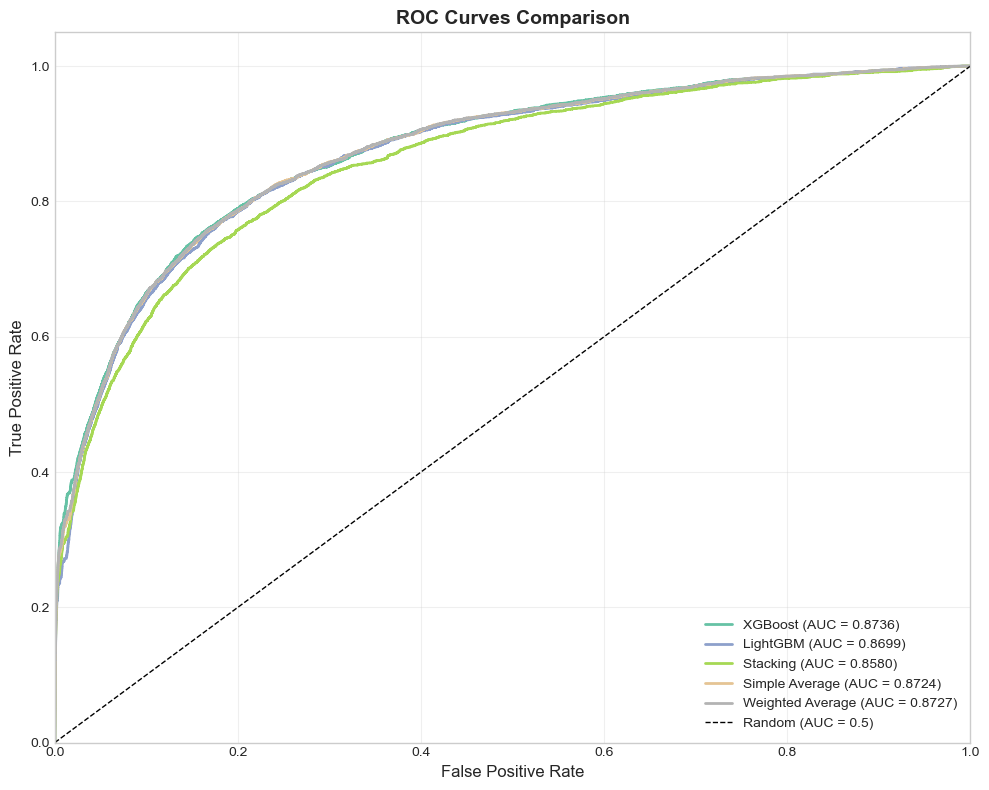


📊 Precision-Recall Curves


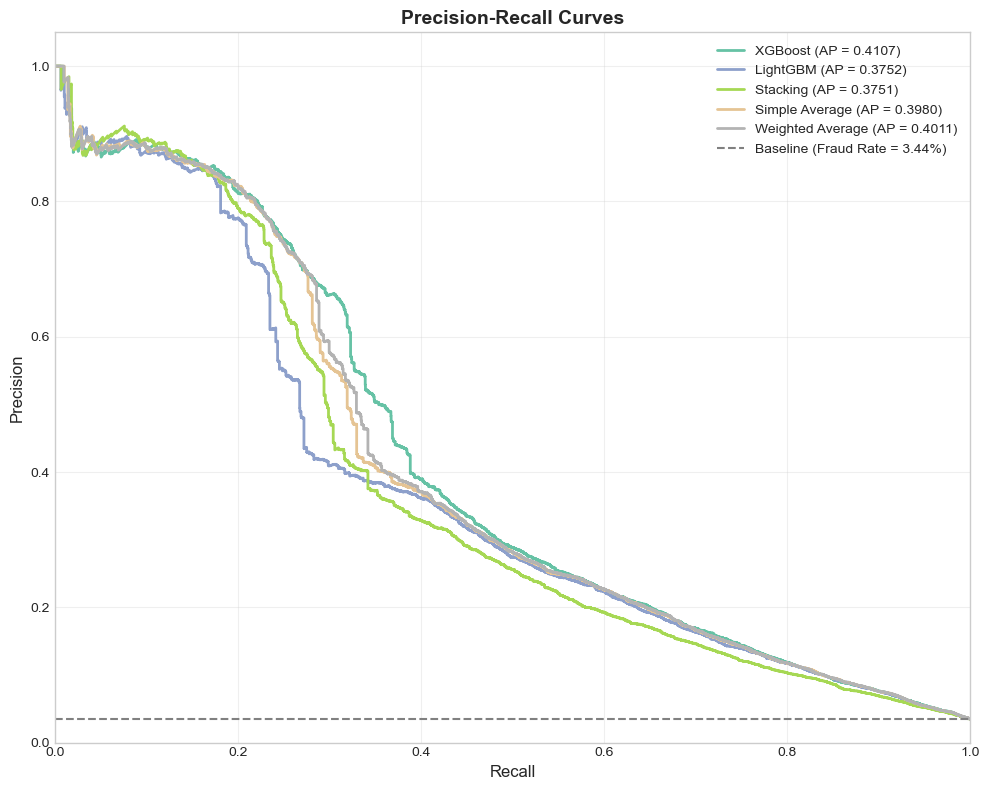


📊 Confusion Matrices


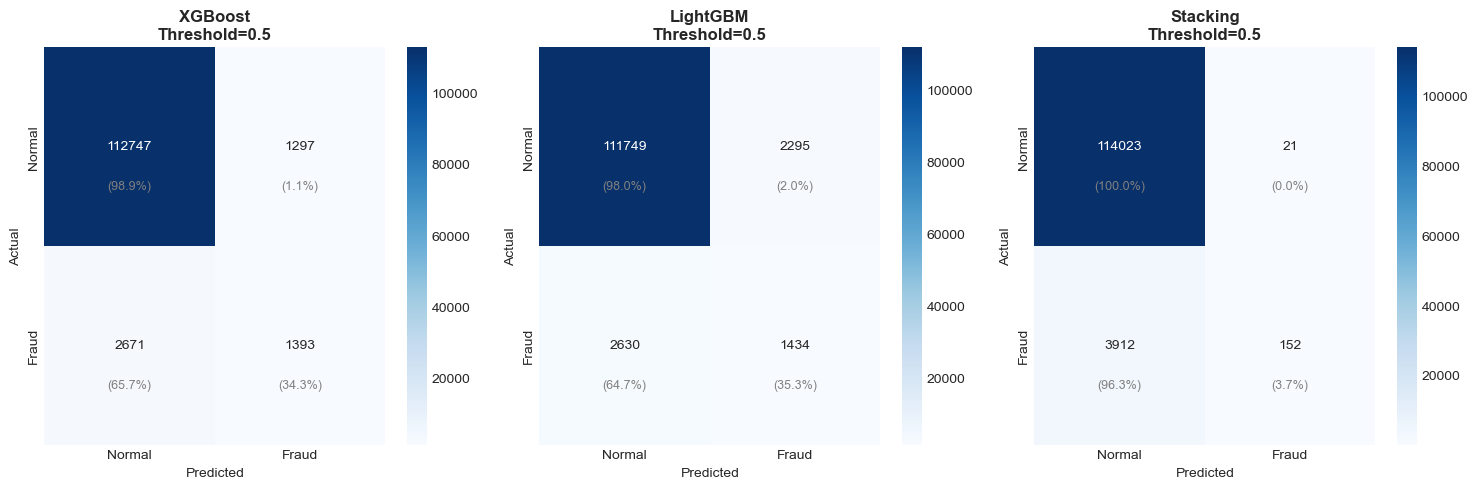


MODEL EVALUATION SUMMARY
           Model  ROC-AUC  Avg Precision  Best Threshold  Precision   Recall  F1-Score
         XGBoost 0.873633       0.410659        0.070934   0.142950 0.753691  0.240320
Weighted Average 0.872727       0.401137        0.070580   0.139698 0.756890  0.235862
  Simple Average 0.872368       0.397979        0.069644   0.137883 0.759104  0.233376
        LightGBM 0.869885       0.375202        0.066192   0.131379 0.769685  0.224447
        Stacking 0.857993       0.375103        0.027321   0.128414 0.738189  0.218771


In [14]:
# CELL 10: Evaluation & Visualization

# Tüm sonuçları topla
results = {
    'XGBoost': xgb_test_pred,
    'LightGBM': lgb_test_pred,
    'Stacking': stacking_test_pred,
    'Simple Average': avg_ensemble_pred,
    'Weighted Average': weighted_ensemble_pred
}

# 1. ROC Curves
print("\n📊 ROC Curves")
plot_roc_curves(results, y_test)

# 2. Precision-Recall Curves
print("\n📊 Precision-Recall Curves")
plot_precision_recall_curves(results, y_test)

# 3. Confusion Matrices (en iyi 3 model için)
print("\n📊 Confusion Matrices")
best_models = {k: results[k] for k in ['XGBoost', 'LightGBM', 'Stacking']}
plot_confusion_matrices(best_models, y_test, threshold=0.5)

# 4. Summary
summary_df = print_evaluation_summary(results, y_test)

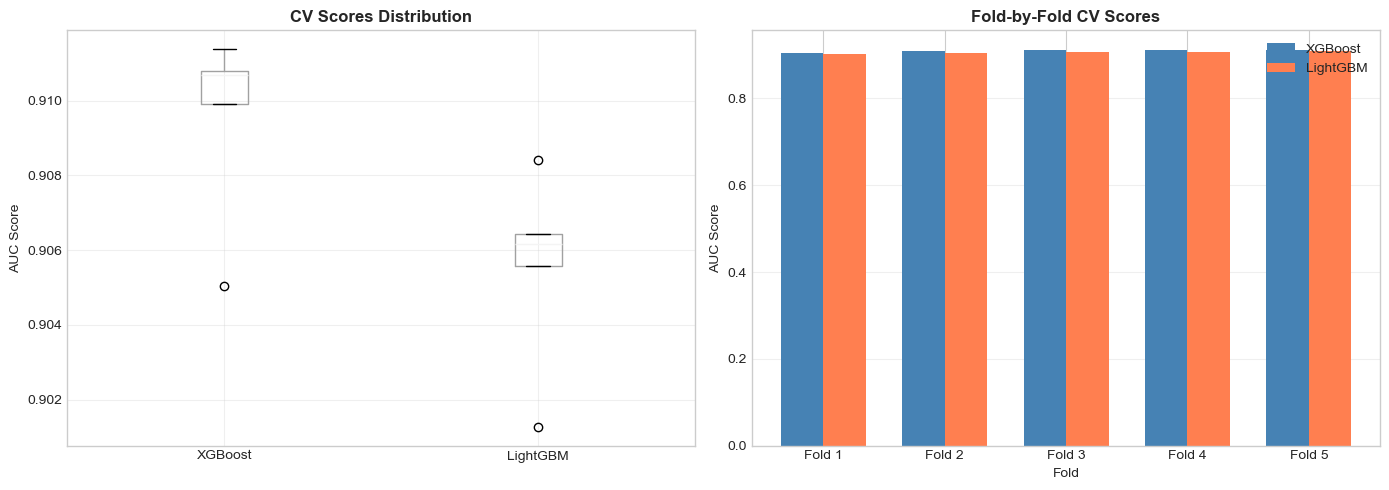


CROSS-VALIDATION SUMMARY
XGBoost:  Mean = 0.9096 ± 0.0023
LightGBM: Mean = 0.9056 ± 0.0024


In [15]:
# CELL 11: Cross-Validation Scores Visualization

# CV skorlarını görselleştir
cv_results = pd.DataFrame({
    'XGBoost': xgb_cv_scores,
    'LightGBM': lgb_cv_scores
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
cv_results.boxplot(ax=axes[0])
axes[0].set_title('CV Scores Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC Score')
axes[0].grid(alpha=0.3)

# Fold-by-fold comparison
x = np.arange(len(xgb_cv_scores))
width = 0.35
axes[1].bar(x - width/2, xgb_cv_scores, width, label='XGBoost', color='steelblue')
axes[1].bar(x + width/2, lgb_cv_scores, width, label='LightGBM', color='coral')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('AUC Score')
axes[1].set_title('Fold-by-Fold CV Scores', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Fold {i+1}' for i in range(len(xgb_cv_scores))])
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Özet istatistikler
print("\n" + "=" * 50)
print("CROSS-VALIDATION SUMMARY")
print("=" * 50)
print(f"XGBoost:  Mean = {np.mean(xgb_cv_scores):.4f} ± {np.std(xgb_cv_scores):.4f}")
print(f"LightGBM: Mean = {np.mean(lgb_cv_scores):.4f} ± {np.std(lgb_cv_scores):.4f}")

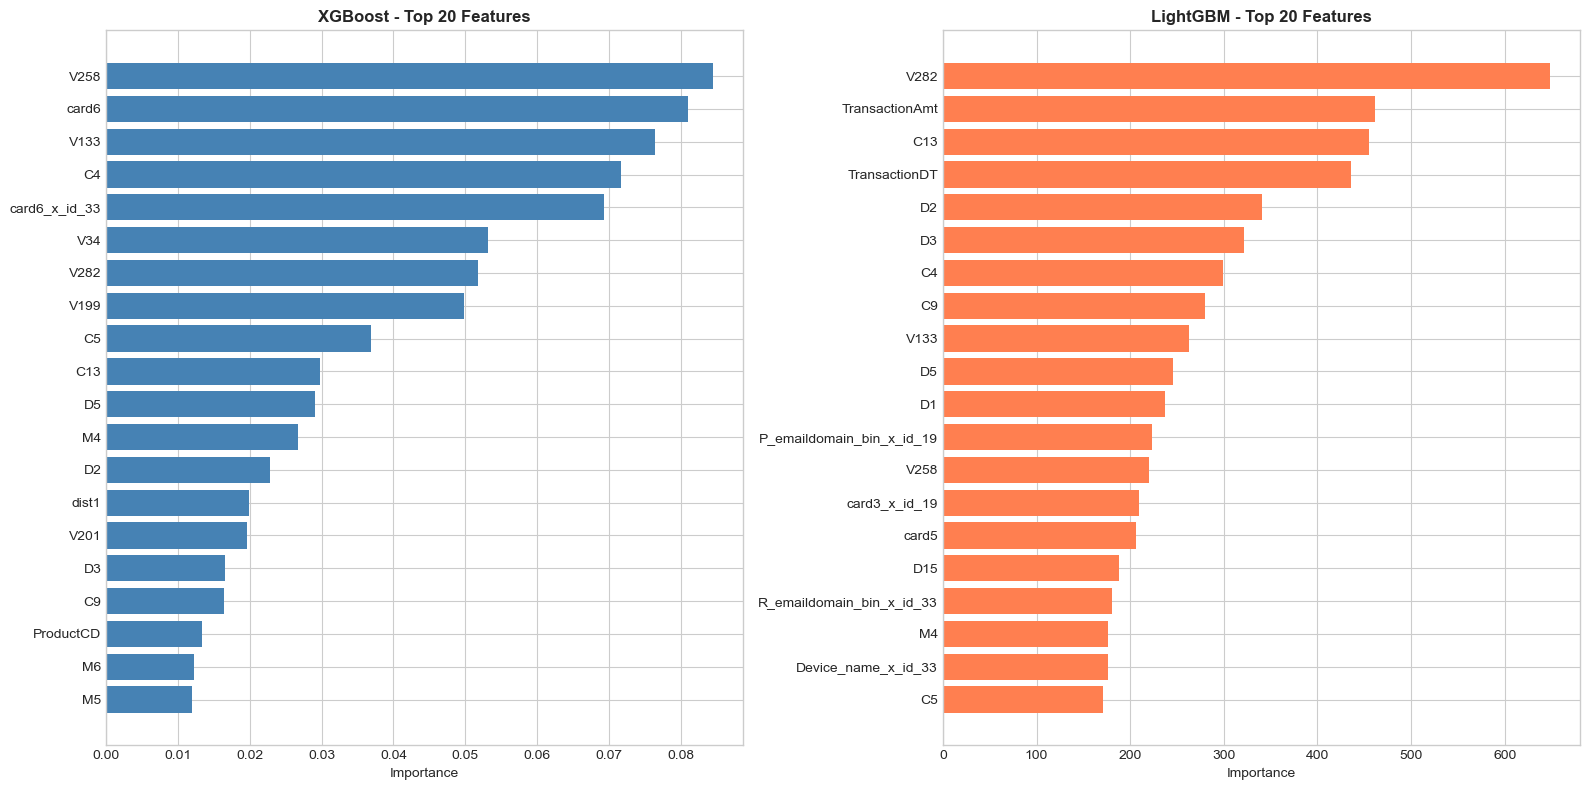

In [16]:
# CELL 12: Feature Importance Comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=True).tail(20)

axes[0].barh(xgb_importance['feature'], xgb_importance['importance'], color='steelblue')
axes[0].set_title('XGBoost - Top 20 Features', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance')

# LightGBM Feature Importance
lgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_final.feature_importances_
}).sort_values('importance', ascending=True).tail(20)

axes[1].barh(lgb_importance['feature'], lgb_importance['importance'], color='coral')
axes[1].set_title('LightGBM - Top 20 Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [ ]:
# CELL 13: Final Summary & Best Model Selection

print("\n" + "=" * 70)
print("🏆 FINAL MODEL SELECTION")
print("=" * 70)

# En iyi modeli seç
best_model_name = summary_df.iloc[0]['Model']
best_auc = summary_df.iloc[0]['ROC-AUC']

print(f"\n✅ Best Model: {best_model_name}")
print(f"   ROC-AUC: {best_auc:.4f}")

# En iyi model tahminlerini kaydet
best_predictions = results[best_model_name]

# # Sonuçları kaydet
# results_df = pd.DataFrame({
#     'y_true': y_test,
#     'xgb_pred': xgb_test_pred,
#     'lgb_pred': lgb_test_pred,
#     'stacking_pred': stacking_test_pred,
#     'best_pred': best_predictions
# })
# results_df.to_csv(DATA / 'model_predictions.csv', index=False)
# print(f"\n✅ Predictions saved to: {DATA / 'model_predictions.csv'}")

# Model bilgileri
print("\n" + "-" * 50)
print("MODEL INFORMATION")
print("-" * 50)
print(f"Training samples: {len(X_train)}")
print(f"Training samples (after SMOTE): {len(X_train_smote)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_cols)}")
print(f"Fraud rate (train): {y_train.mean():.2%}")
print(f"Fraud rate (test): {y_test.mean():.2%}")


🏆 FINAL MODEL SELECTION

✅ Best Model: XGBoost
   ROC-AUC: 0.8736

✅ Predictions saved to: c:\Users\Abdulkadir\Desktop\Uygulama çalışmaları\VM_odev\data\model_predictions.csv

--------------------------------------------------
MODEL INFORMATION
--------------------------------------------------
Training samples: 472432
Training samples (after SMOTE): 683749
Test samples: 118108
Features: 57
Fraud rate (train): 3.51%
Fraud rate (test): 3.44%


In [18]:
# CELL 14: Kaggle Submission Preparation (Optional)

def prepare_kaggle_submission(model, X_train, y_train, kaggle_test_path, output_path):
    """
    Kaggle submission dosyası hazırlar.
    """
    # Kaggle test verisini yükle
    kaggle_test = pd.read_csv(kaggle_test_path, low_memory=False)
    submission_ids = kaggle_test['TransactionID']
    
    # Aynı feature engineering pipeline'ını uygula
    # (Bu kısım submission.ipynb'de detaylı yapıldı)
    
    print(f"Kaggle test shape: {kaggle_test.shape}")
    print(f"Submission IDs: {len(submission_ids)}")
    
    return None  # submission.ipynb kullanılacak

# NOT: Kaggle submission için submission.ipynb kullanın
print("\n💡 Kaggle submission için notebooks/submission.ipynb dosyasını kullanın.")


💡 Kaggle submission için notebooks/submission.ipynb dosyasını kullanın.
